In [3]:
import re
import os
import nltk
import eli5
import spacy
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from spacy import displacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

path_data = r'/media/dmitriy/Disk/Downloads/ai_nlp_hw_data/hw_6/'

## Анализ тональности

In [4]:
train_df = pd.read_csv(os.path.join(path_data, r'train.tsv'), delimiter="\t")
test_df = pd.read_csv(os.path.join(path_data, r'test.tsv'), delimiter="\t")

### По ключевым словам

In [6]:
positive_words = ('love', 'great', 'best', '7/10', '810', 'refreshing', 'wonderfully', 'funniest',
                  'erotic', 'excellent', 'carrey', 'flawless', 'hooked',
                  'superb', 'perfect', 'subtle', 'highly', 'vengeance',
                  'incredible', 'surprisingly', 'perfectly', 'rare', 'driven',
                  'finest', 'australia', 'touching', 'favorite', 'appreciated',
                  'chavez', 'enjoyable', 'scariest', '9/10', 'underrated',
                  '10/10', 'amazing', 'steals', 'tears', 'whoopi', 'delightful',
                  'flight', 'squirrel', 'units', 'kitty', 'enjoyed',
                  'dealing', 'bound')
negative_words = ('4/10', 'disappointment', '3/10', 'waste', 'poorly', 'worst', 'lacks',
                   '2/10','laughable', 'fails', 'awful', 'avoid', 'boring',
                   'disappointing', 'forgettable', '2/10', 'alright', 'unfunny',
                   'pointless', 'mediocre', 'lame', 'save', 'lousy', 'mst3k',
                   'horrible', 'badly', 'wooden', 'weak', 'baldwin', 'redeeming',
                   'mildly', 'dull', 'worse', 'mess', 'dreadful', 'britney',
                   '1/10', 'annoying', 'unwatchable', 'photo', 'poor', 'generous',
                   'sources', 'terrible', 'bored', 'boredom', 'insult', 'wonder',
                   'uninteresting', 'ridiculous', 'cardboard', 'unfortunately',
                   'miscast', 'ludicrous', 'refer', 'hoping', 'obnoxious', 'basically')
positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()
accuracy = correct_count / len(test_df)
print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 75.72%


### Обработка текста

In [7]:
pattern = re.compile('<br\s?\/>|<br>')
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dmitriy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
mystopwords = stopwords.words("english") + ['the', 'a']


def remove_punktuation(text):
    return re.sub(r'[^\w\s\d]', '', text)


def lower_case(text):
    text = str(text).lower()
    return ' '.join(tokenizer.tokenize(text))


def remove_stopwords(text):
    text = tokenizer.tokenize(text)
    text = [w for w in text if w not in mystopwords]
    return ' '.join(text)
  
    
def normalize(text):
    text = remove_punktuation(text)
    text = lower_case(text)
    text = remove_stopwords(text)
    return text

In [10]:
train_df['review'] = train_df['review'].apply(normalize)
test_df['review'] = test_df['review'].apply(normalize)

### Мешок слов

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

### Логистическая регрессия

In [12]:
vectorizer = CountVectorizer()
classifier = LogisticRegression()
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['review'], train_df['is_positive'])

/home/dmitriy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [13]:
def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))


eval_model(model, test_df)

Test accuracy = 86.99%


### Веса

In [14]:
eli5.show_weights(classifier, vec=vectorizer, top=10)

/home/dmitriy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [16]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/home/dmitriy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Примеры ннправильной классификации

In [17]:
preds_vount_vect = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds_vount_vect != test_df['is_positive'])[0])
eli5.show_prediction(classifier, 
                     test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

/home/dmitriy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### TF-IDF

In [18]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 88.58%


In [19]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

/home/dmitriy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+7.220,great
+6.295,excellent
+5.262,best
+4.709,perfect
+4.676,wonderful
+4.232,amazing
+4.230,well
+4.209,favorite
+4.096,love
+3.857,loved


In [20]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, 
                     test_df['review'].iloc[1], 
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

Positive


In [21]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, 
                     test_df['review'].iloc[6], 
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

Negative


/home/dmitriy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### N-граммы слов

In [22]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 88.28%


In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 87.55%


In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5))
classifier = LogisticRegression()
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 86.62%


### N-граммы символов

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 87.56%


In [27]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, 
                     test_df['review'].iloc[1], 
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

Positive


/home/dmitriy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
vectorizer = TfidfVectorizer(ngram_range=(3, 7), analyzer='char')
classifier = LogisticRegression()
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 88.33%


In [29]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, 
                     test_df['review'].iloc[1], 
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

Positive


/home/dmitriy/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Лемматизация и стемминг

#### Классификация на лемматизованных текстах

In [30]:
nlp = spacy.load('en_core_web_sm', disable=['parser'])
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/dmitriy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
def lemmatized_words(text):
    text_lem = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_lem)

In [32]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/dmitriy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
train_df['lemmatized'] = train_df['review'].apply(lemmatized_words)
test_df['lemmatized'] = test_df['review'].apply(lemmatized_words)

In [34]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['lemmatized'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 87.97%


#### Классификация на лемматизованных основах

In [35]:
stemmer = PorterStemmer()


def stemmed_words(text):
    text_stem = [stemmer.stem(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_stem)


train_df['stemmed'] = train_df['review'].apply(stemmed_words)
test_df['stemmed'] = test_df['review'].apply(stemmed_words)

In [36]:
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
model.fit(train_df['stemmed'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 82.37%


#### Глубокое обучение

<BarContainer object of 253 artists>

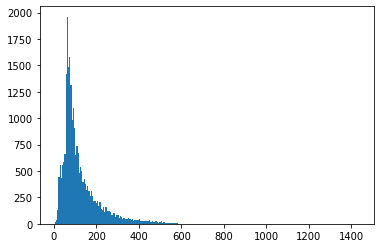

In [37]:
_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

In [38]:
words_counter = Counter((word for text in train_df.review for word in text.lower().split()))
word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)
print('Words count', len(word2idx))

Words count 20441


In [41]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=int)
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=int)
    return data


X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

In [42]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1308224   
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1308995 (4.99 MB)
Trainable params: 1308995 (4.99 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

2023-12-20 22:05:22.979235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1549 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:03:00.0, compute capability: 7.5


In [43]:
model.fit(X_train, 
          train_df.is_positive, 
          batch_size=128, 
          epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10


2023-12-20 22:05:25.520453: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 22:05:26.308627: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1a0d0cfd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 22:05:26.308664: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-12-20 22:05:26.317558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 22:05:28.235007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-20 22:05:28.353535: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 [==============================] - 46s 208ms/step - loss: 0.5522 - accuracy: 0.7857 - val_loss: 0.3357 - val_accuracy: 0.8631
Epoch 2/10
196/196 [==============================] - 33s 166ms/step - loss: 0.2583 - accuracy: 0.8964 - val_loss: 0.2820 - val_accuracy: 0.8809
Epoch 3/10
196/196 [==============================] - 26s 132ms/step - loss: 0.1598 - accuracy: 0.9415 - val_loss: 0.2839 - val_accuracy: 0.8827
Epoch 4/10
196/196 [==============================] - 21s 108ms/step - loss: 0.0890 - accuracy: 0.9724 - val_loss: 0.3122 - val_accuracy: 0.8786
Epoch 5/10
196/196 [==============================] - 18s 92ms/step - loss: 0.0423 - accuracy: 0.9913 - val_loss: 0.3523 - val_accuracy: 0.8743
Epoch 6/10
196/196 [==============================] - 16s 80ms/step - loss: 0.0179 - accuracy: 0.9980 - val_loss: 0.3977 - val_accuracy: 0.8704
Epoch 7/10
 94/196 [=============>................] - ETA: 8s - loss: 0.0079 - accuracy: 0.9998

2023-12-20 22:08:10.563692: W tensorflow/compiler/xla/service/gpu/runtime/graph_launch.cc:156] Evict all gpu graphs from executor 0x560759025a00


196/196 [==============================] - 15s 77ms/step - loss: 0.0076 - accuracy: 0.9996 - val_loss: 0.4298 - val_accuracy: 0.8706
Epoch 8/10
196/196 [==============================] - 16s 82ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4588 - val_accuracy: 0.8697
Epoch 9/10
196/196 [==============================] - 10s 53ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4814 - val_accuracy: 0.8692
Epoch 10/10
196/196 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

2023-12-20 22:08:52.804464: W tensorflow/compiler/xla/service/gpu/runtime/graph_launch.cc:156] Evict all gpu graphs from executor 0x560759025a00


196/196 [==============================] - 9s 46ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5005 - val_accuracy: 0.8688


In [44]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 2s 3ms/step - loss: 0.5005 - accuracy: 0.8688


[0.5004820823669434, 0.8687999844551086]